# **Loan Approval Project**

-------


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## **Data Loading and Initial Look**

- Load the data.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Training Data (First 5 rows):")
print(train.head())

Training Data (First 5 rows):
   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length 

- Count the number of rows (data points) and features.

In [3]:
train_shape = train.shape
test_shape = test.shape

print(f"Training Data: {train_shape[0]} rows, {train_shape[1]} features")
print(f"Test Data: {test_shape[0]} rows, {test_shape[1]} features")

Training Data: 58645 rows, 13 features
Test Data: 39098 rows, 12 features


- Any missing values?

In [4]:
missing_values_train = train.isnull().sum()

missing_values_test = test.isnull().sum()

print("Missing Values in Training Data:")
print(missing_values_train[missing_values_train > 0])

print("\nMissing Values in Test Data:")
print(missing_values_test[missing_values_test > 0])

Missing Values in Training Data:
Series([], dtype: int64)

Missing Values in Test Data:
Series([], dtype: int64)


Make a table, where each row is a feature or collection of features:

- Is the feature categorical or numerical
- What values?
  - e.g. for categorical: "0,1,2"
  - e.g. for numerical specify the range

In [5]:
df = pd.read_csv('train.csv')

feature_details = []

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        feature_type = 'Numerical'
        min_val = df[col].min()
        max_val = df[col].max()
        values = f"Range: {min_val} to {max_val}"
    else:
        feature_type = 'Categorical'
        unique_vals = df[col].unique()
        if len(unique_vals) > 10:
            values = f"Unique values (first 10): {unique_vals[:10]}"
        else:
            values = f"Possible values: {list(unique_vals)}"

    feature_details.append({
        'Feature': col,
        'Type': feature_type,
        'Possible Values / Range': values
    })

feature_df = pd.DataFrame(feature_details)

print(feature_df)

                       Feature         Type  \
0                           id    Numerical   
1                   person_age    Numerical   
2                person_income    Numerical   
3        person_home_ownership  Categorical   
4            person_emp_length    Numerical   
5                  loan_intent  Categorical   
6                   loan_grade  Categorical   
7                    loan_amnt    Numerical   
8                loan_int_rate    Numerical   
9          loan_percent_income    Numerical   
10   cb_person_default_on_file  Categorical   
11  cb_person_cred_hist_length    Numerical   
12                 loan_status    Numerical   

                              Possible Values / Range  
0                                   Range: 0 to 58644  
1                                    Range: 20 to 123  
2                              Range: 4200 to 1900000  
3   Possible values: ['RENT', 'OWN', 'MORTGAGE', '...  
4                                 Range: 0.0 to 123.0  
5   P

In [6]:
train[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']].describe()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


In [7]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status']
for col in categorical_cols:
    print(f"{col}: {train[col].unique()}")

person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
loan_grade: ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file: ['N' 'Y']
loan_status: [0 1]


- How many missing values

In [8]:
test_data = pd.read_csv('test.csv')

X_test = test_data.drop(columns=['id'])
print(X_test.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length'],
      dtype='object')


In [9]:
df = pd.read_csv('train.csv')

missing_values = df.isnull().sum()

missing_values_df = pd.DataFrame({
    'Feature': missing_values.index,
    'Missing Values': missing_values.values,
    'Percentage of Missing Values (%)': (missing_values.values / len(df)) * 100
})

print(missing_values_df)


                       Feature  Missing Values  \
0                           id               0   
1                   person_age               0   
2                person_income               0   
3        person_home_ownership               0   
4            person_emp_length               0   
5                  loan_intent               0   
6                   loan_grade               0   
7                    loan_amnt               0   
8                loan_int_rate               0   
9          loan_percent_income               0   
10   cb_person_default_on_file               0   
11  cb_person_cred_hist_length               0   
12                 loan_status               0   

    Percentage of Missing Values (%)  
0                                0.0  
1                                0.0  
2                                0.0  
3                                0.0  
4                                0.0  
5                                0.0  
6                         

In [10]:
df = pd.read_csv('train.csv')

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

outliers = {}

for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

outliers_df = pd.DataFrame(outliers.items(), columns=['Feature', 'Outliers Count'])
print(outliers_df)

                      Feature  Outliers Count
0                          id               0
1                  person_age            2446
2               person_income            2411
3           person_emp_length            1274
4                   loan_amnt            2045
5               loan_int_rate              34
6         loan_percent_income            1210
7  cb_person_cred_hist_length            1993
8                 loan_status            8350


- Do you see any outliers?
  - Define outlier.

Outlier Interpretation and Implications
- Age, Income, Employment Length: Outliers in these fields can indicate either exceptional cases or errors. For instance, very young or very old applicants may be anomalies, or income and employment length may reflect either extreme wealth or unusual work history.
- Loan Amount & Loan Percentage: Outliers in loan amounts and percentages are significant as they may indicate clients with higher loan requests, possibly due to specific needs or financial situations. These could skew the model if not handled properly.
- Credit History Length: A very short or long credit history might indicate an outlier. Individuals with little or no credit history could be seen as high-risk applicants, and very long histories could indicate a different credit profile.
- Loan Status: Outliers here might indicate a skewed class distribution, which is a common challenge in classification problems. This could require balancing techniques if the classes are highly imbalanced.

Dealing with Outliers

Outliers can have a significant impact on models, particularly in regression or machine learning algorithms that are sensitive to extreme values. Some common strategies to handle them include:

- Removing outliers: For features like person_age or loan_amnt, you might choose to remove rows where the outliers are extreme.
- Capping values: For certain features, you could cap the values at a reasonable threshold (e.g., restricting loan amounts to a certain range).
- Transforming data: Applying logarithmic transformations to variables like income or loan_amount can help to reduce the influence of outliers.
- Using robust models: Some models, such as decision trees, are less sensitive to outliers than others like linear regression.

- For classification is there class imbalance?

- What is the target:
  - Classification: how is the target encoded (e.g. 0 and 1)?
  - Regression: what is the range?

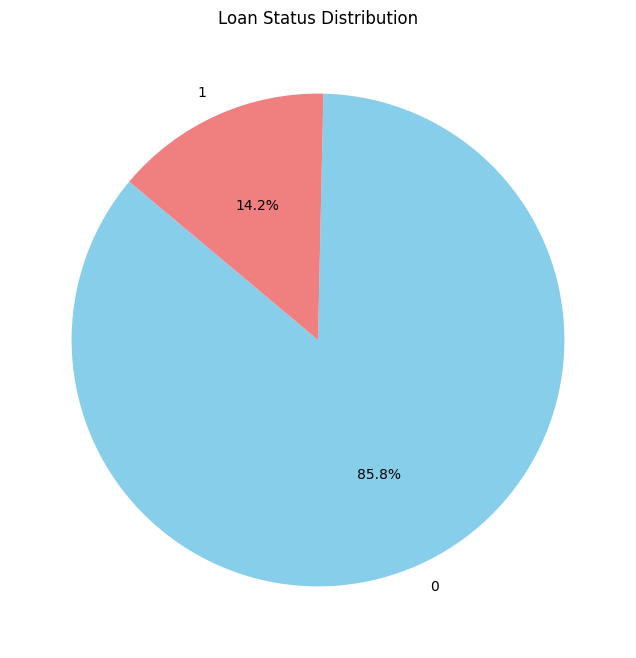

In [21]:
data = pd.read_csv('train.csv')
class_counts = data['loan_status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Loan Status Distribution')
plt.show()

What to do if there is a class imbalance?
There are several techniques you can use in this scenario class imbalance:

1. Resampling Techniques


Oversampling the minority class (loan_status = 1) to match the number of samples in the majority class (loan_status = 0).
Undersampling the majority class to reduce the number of samples in loan_status = 0.
Example of Oversampling (using SMOTE method):

In [12]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

In [13]:
from sklearn.model_selection import train_test_split

# Training and testing sets 80% train, 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv')

X = data.drop('loan_status', axis=1)
y = data['loan_status']

# Training and testing sets 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (46916, 12)
Testing data shape: (11729, 12)


## **Data Visualization**

- For classification: compare histogram every feature between the classes. Lots of examples of this in class.

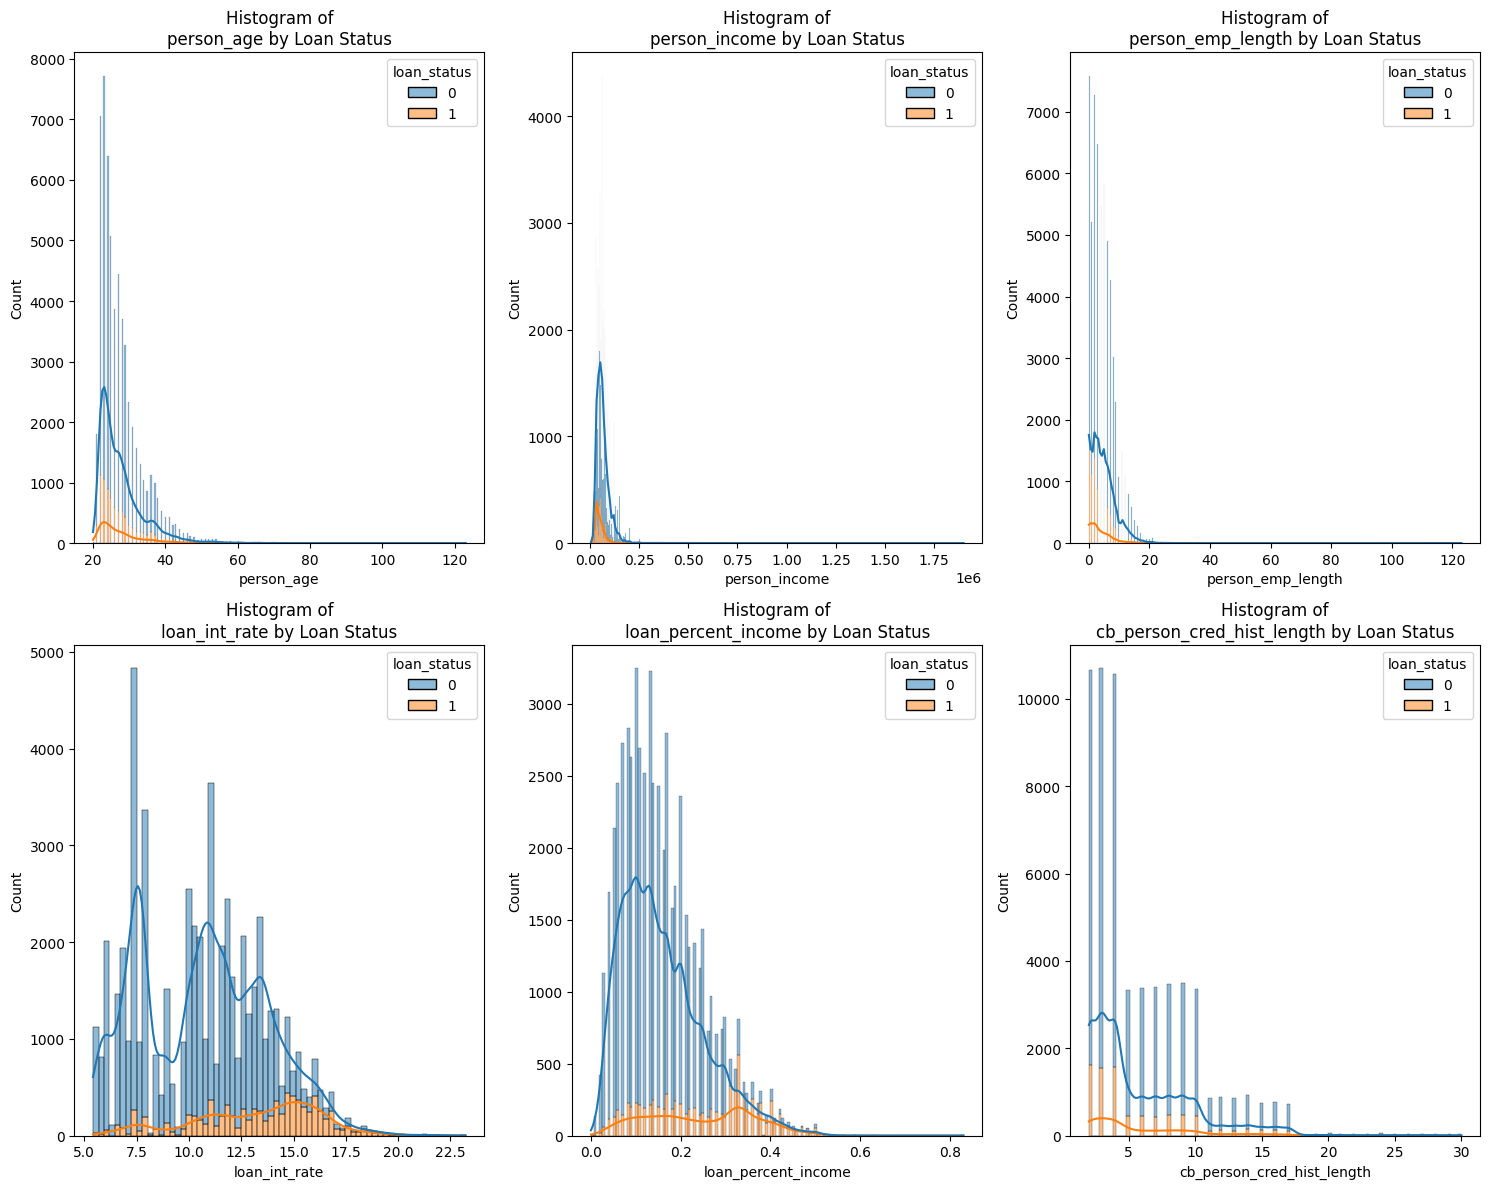

In [19]:
numerical_features = ['person_age', 'person_income', 'person_emp_length',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=data, x=feature, hue='loan_status', kde=True, multiple='stack')
    plt.title(f'Histogram of\n{feature} by Loan Status', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.show()

- Compare histograms of the features between the classes.

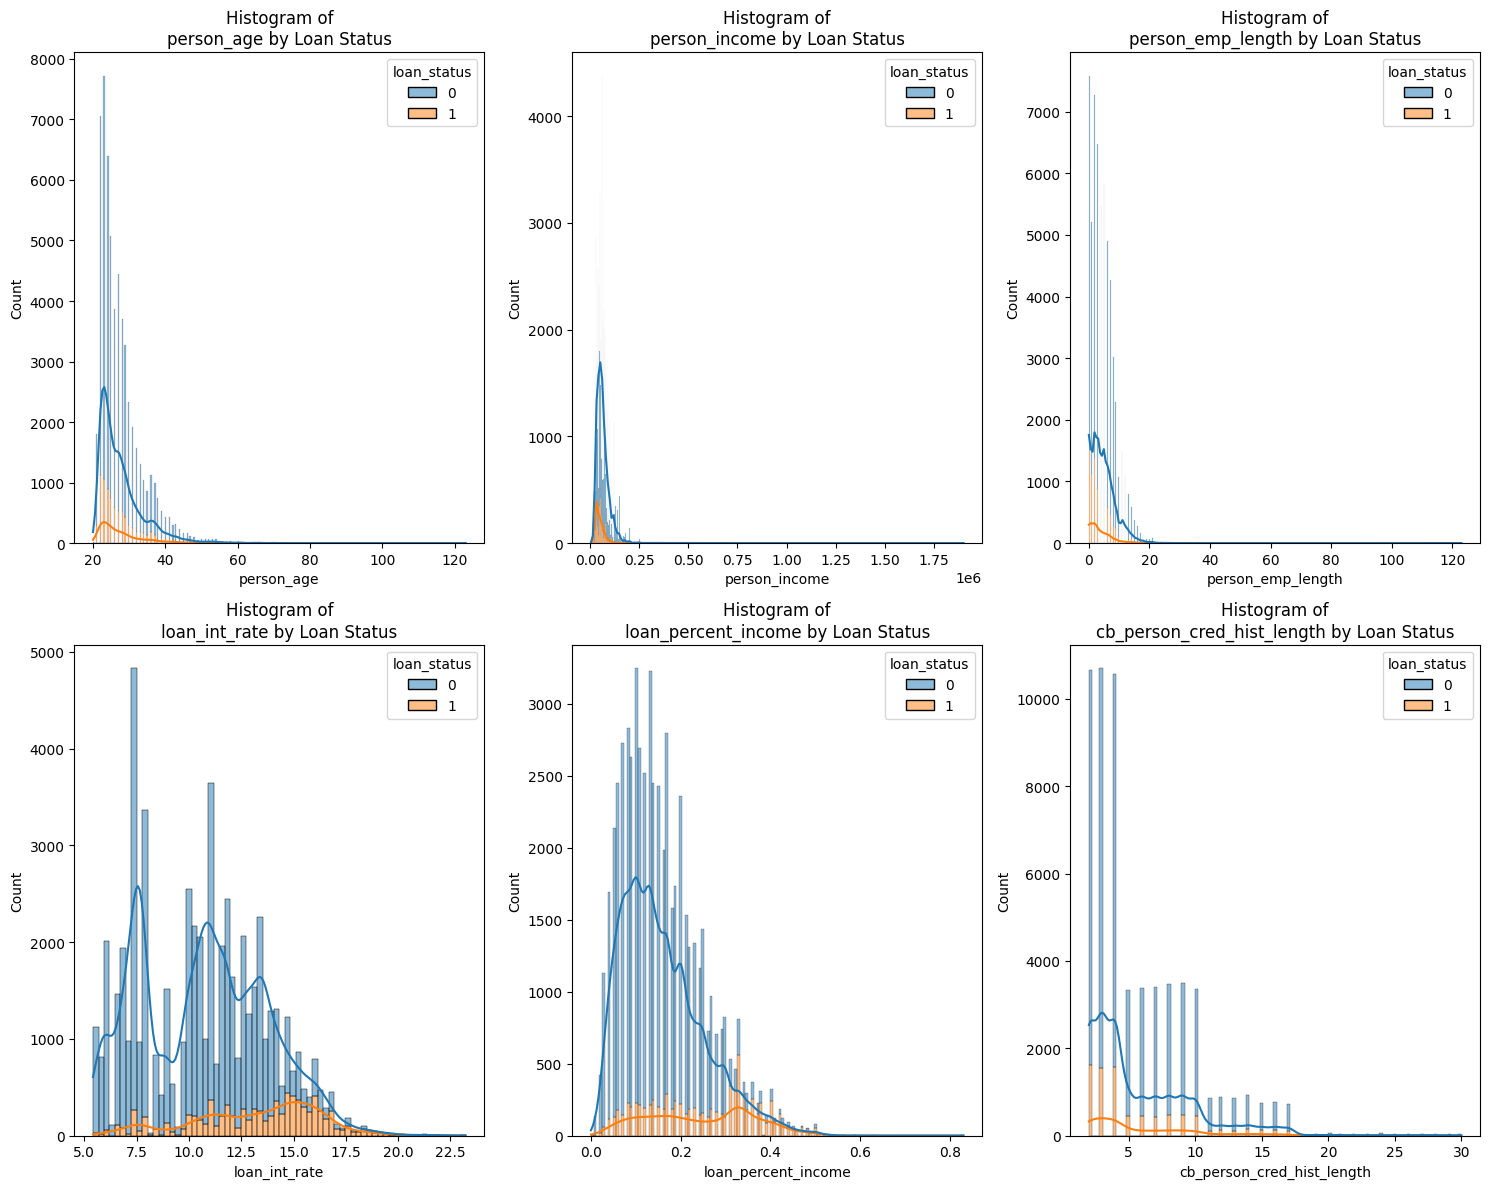

In [20]:
numerical_features = ['person_age', 'person_income', 'person_emp_length',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

plt.figure(figsize=(15, 12))

for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=data, x=feature, hue='loan_status', kde=True, multiple='stack')
    plt.title(f'Histogram of\n{feature} by Loan Status', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

- Note that for categorical features, often times the information in the histogram could be better presented in a table

In [18]:
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade']

for feature in categorical_features:
    crosstab = pd.crosstab(data[feature], data['loan_status'], margins=True, margins_name="Total")
    print(f"Distribution of Loan Status by {feature}:\n")
    display(crosstab)
    print("\n" + "="*60 + "\n")


Distribution of Loan Status by person_home_ownership:



loan_status,0,1,Total
person_home_ownership,,,
MORTGAGE,23341,1483,24824
OTHER,74,15,89
OWN,3095,43,3138
RENT,23785,6809,30594
Total,50295,8350,58645




Distribution of Loan Status by loan_intent:



loan_status,0,1,Total
loan_intent,,,
DEBTCONSOLIDATION,7404,1729,9133
EDUCATION,10949,1322,12271
HOMEIMPROVEMENT,5189,1091,6280
MEDICAL,8985,1949,10934
PERSONAL,8686,1330,10016
VENTURE,9082,929,10011
Total,50295,8350,58645




Distribution of Loan Status by loan_grade:



loan_status,0,1,Total
loan_grade,,,
A,19952,1032,20984
B,18313,2087,20400
C,9542,1494,11036
D,2046,2988,5034
E,378,631,1009
F,58,91,149
G,6,27,33
Total,50295,8350,58645


- Make comments on what features look most promising for ML task.

Promising Features for Machine Learning:

- loan_int_rate: If the loan interest rate varies significantly between loan approval statuses, it can be a crucial feature.
- person_income: Higher income might correlate with a higher likelihood of loan approval, especially if income levels differ significantly between the two classes.
- loan_amnt: If the loan amount differs significantly between loan approval statuses, this could be a valuable feature.
- loan_grade: This categorical feature could also provide valuable insights into loan approval predictions if it shows clear separation between the classes.

## **Data Cleaning and Preperation for Machine Learning**

- Perform any data cleaning. Be clear what are you doing, for what feature

In [23]:
missing_values = data.isnull().sum()

numerical_features = ['person_age', 'person_income', 'person_emp_length',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
data[numerical_features] = data[numerical_features].fillna(data[numerical_features].median())

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade']
for feature in categorical_features:
    data[feature] = data[feature].fillna(data[feature].mode()[0])

# I used the IQR method to detect outliers in numerical features.

def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

for feature in numerical_features:
    data = remove_outliers(data, feature)

# I one-hot encoding for nominal categorical features
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

data = data.drop(columns=['id'])

data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
1,-1.053729,-0.141831,0.468431,4000,0.893562,-1.037659,N,-1.052362,0,False,...,False,True,False,False,False,True,False,False,False,False
2,0.728062,-1.317409,1.060832,6000,-0.581661,0.643850,N,1.846697,0,False,...,False,False,True,False,False,False,False,False,False,False
3,0.982604,0.463247,2.838036,12000,0.150978,0.163419,N,0.034785,0,False,...,False,False,False,True,True,False,False,False,False,False
4,-1.053729,0.031049,-0.716372,6000,-1.238053,-0.677336,N,-0.689979,0,False,...,False,True,False,False,False,False,False,False,False,False
5,0.218979,-0.617248,-0.716372,9000,-0.568401,0.523742,N,0.034785,0,False,...,False,False,False,True,False,False,False,False,False,False


Explanation:
- Missing Values: I handled missing values by filling numerical columns with the median and categorical columns with the mode.
- Outliers: I used the IQR method to remove outliers from the numerical columns.
- Encoding Categorical Features: I applied one-hot encoding to categorical variables like person_home_ownership, loan_intent, and loan_grade.
- Scaling Numerical Features: I used StandardScaler to scale numerical features, ensuring they have a mean of 0 and a standard deviation of 1.
- Removing Irrelevant Features: The id column was dropped as it is unlikely to contribute to predictions.

Determinine if rescaling is important for your Machine Learning model.
- If so select strategy for each feature.
- Apply rescaling.

In [24]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['person_age', 'person_income', 'person_emp_length',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

data.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
1,-1.053729,-0.141831,0.468431,4000,0.893562,-1.037659,N,-1.052362,0,False,...,False,True,False,False,False,True,False,False,False,False
2,0.728062,-1.317409,1.060832,6000,-0.581661,0.643850,N,1.846697,0,False,...,False,False,True,False,False,False,False,False,False,False
3,0.982604,0.463247,2.838036,12000,0.150978,0.163419,N,0.034785,0,False,...,False,False,False,True,True,False,False,False,False,False
4,-1.053729,0.031049,-0.716372,6000,-1.238053,-0.677336,N,-0.689979,0,False,...,False,True,False,False,False,False,False,False,False,False
5,0.218979,-0.617248,-0.716372,9000,-0.568401,0.523742,N,0.034785,0,False,...,False,False,False,True,False,False,False,False,False,False


Why This is Important
- Improved Convergence: Algorithms like Logistic Regression, SVM, and k-NN converge faster when features are scaled.
- Model Performance: Scaling ensures that all features contribute equally to the model's performance, preventing features with large values from dominating the learning process.

What Happens to the Categorical Features
- Categorical Features: After one-hot encoding, categorical features are represented as binary columns (0 or 1), which don't require rescaling.

- Visualize the features before and after cleaning and rescaling.

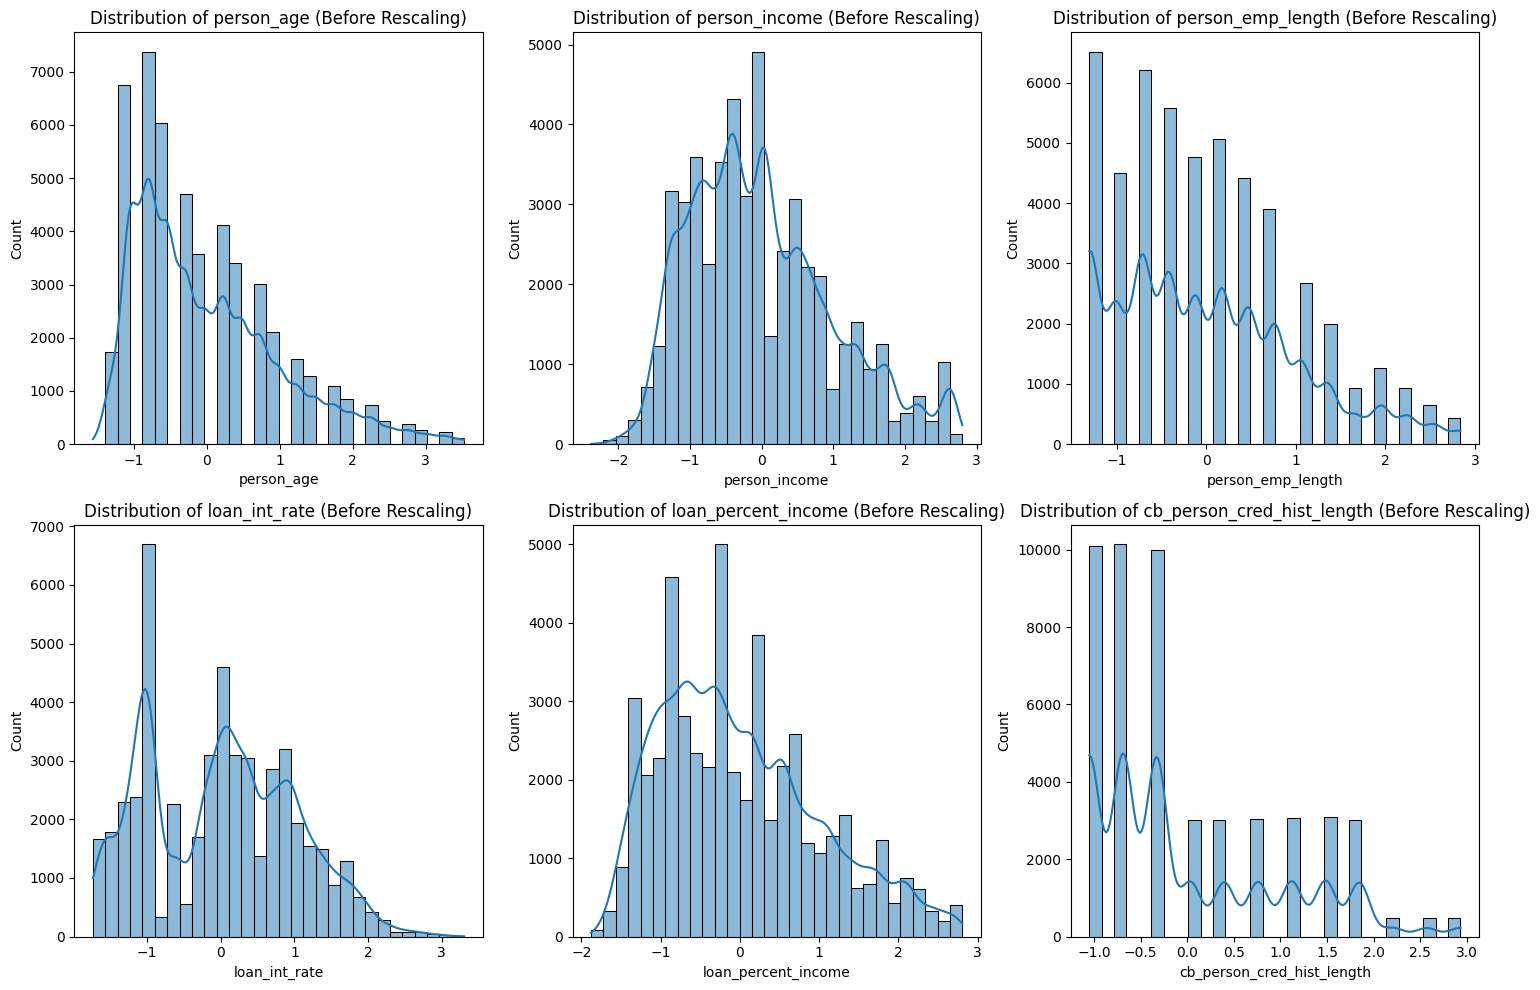

In [25]:
numerical_features = ['person_age', 'person_income', 'person_emp_length',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature} (Before Rescaling)')

plt.tight_layout()
plt.show()

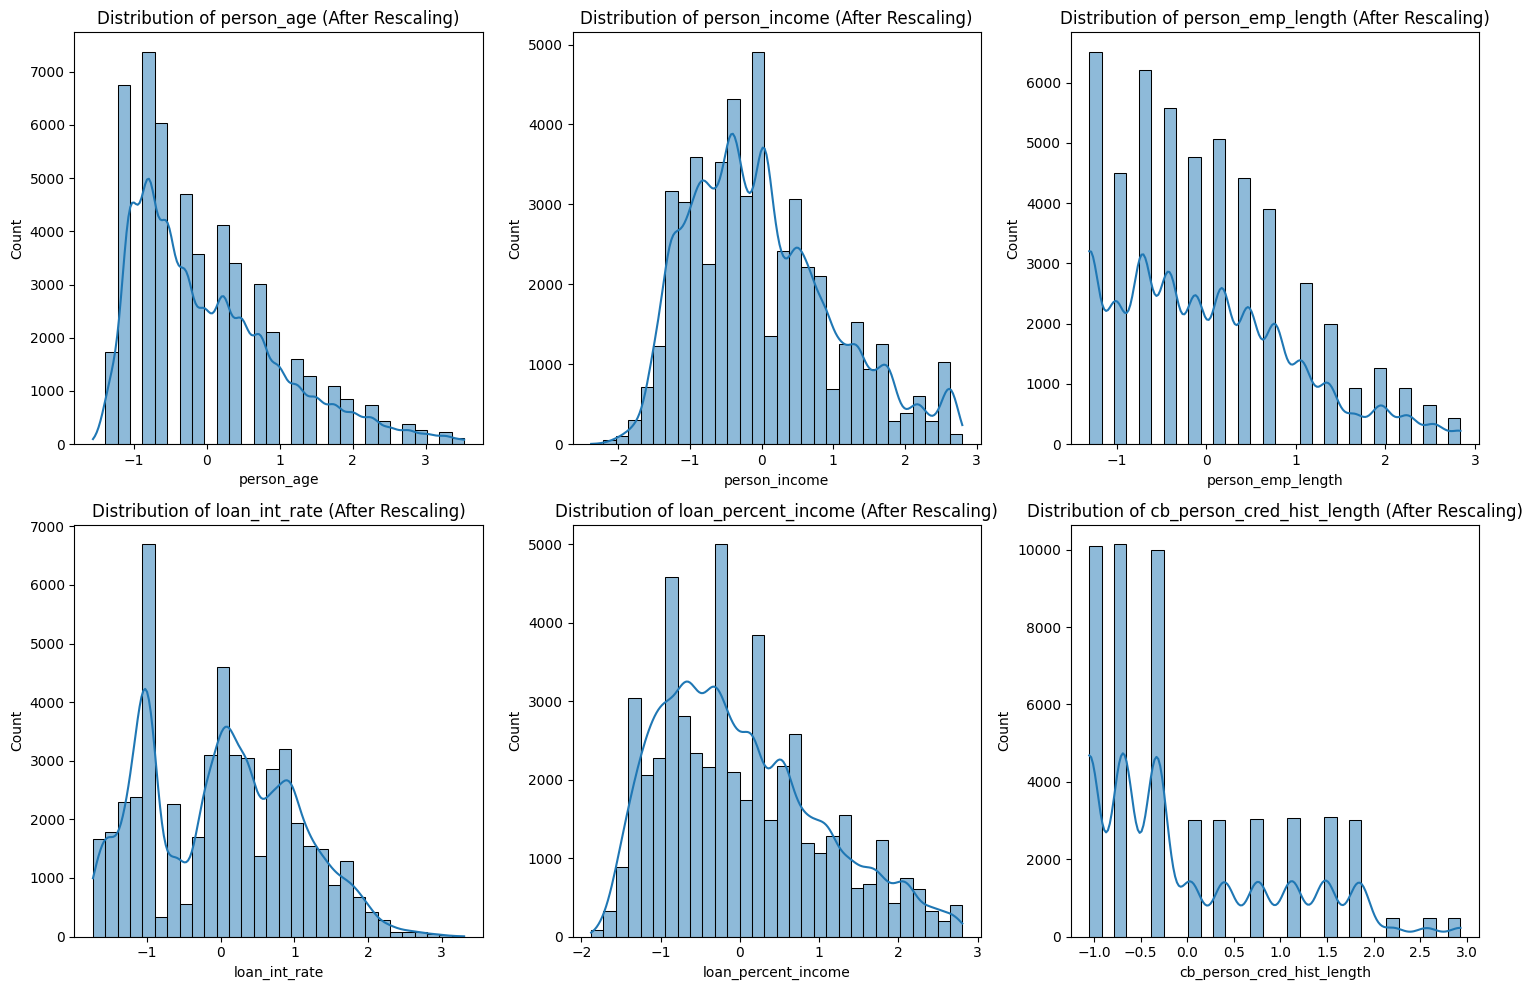

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature} (After Rescaling)')

plt.tight_layout()
plt.show()

What I Observed:

Before Rescaling: Some features may have skewed distributions or widely varying ranges.

After Rescaling: All numerical features will have been standardized to a mean of 0 and a standard deviation of 1, so the distributions should now be centered around 0 with similar variance.

Identify the Categorical Features
From the dataset, these are the categorical features:

- person_home_ownership
- loan_intent
- loan_grade
- cb_person_default_on_file


- One-hot encode your categorical features.

In [27]:
already_encoded_columns = [
    'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT',
    'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
    'loan_intent_PERSONAL', 'loan_intent_VENTURE',
    'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G'
]

categorical_features = []

data_encoded = pd.get_dummies(data, drop_first=True)

print(data_encoded.head())

   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1   -1.053729      -0.141831           0.468431       4000       0.893562   
2    0.728062      -1.317409           1.060832       6000      -0.581661   
3    0.982604       0.463247           2.838036      12000       0.150978   
4   -1.053729       0.031049          -0.716372       6000      -1.238053   
5    0.218979      -0.617248          -0.716372       9000      -0.568401   

   loan_percent_income  cb_person_cred_hist_length  loan_status  \
1            -1.037659                   -1.052362            0   
2             0.643850                    1.846697            0   
3             0.163419                    0.034785            0   
4            -0.677336                   -0.689979            0   
5             0.523742                    0.034785            0   

   person_home_ownership_OTHER  person_home_ownership_OWN  ...  \
1                        False                       True  ...   
2 

In [28]:
# i dropped 'loan_amnt' and 'person_home_ownership_OTHER'
data_cleaned = data_encoded.drop(columns=['loan_amnt', 'person_home_ownership_OTHER'])

print(data_cleaned.head())

   person_age  person_income  person_emp_length  loan_int_rate  \
1   -1.053729      -0.141831           0.468431       0.893562   
2    0.728062      -1.317409           1.060832      -0.581661   
3    0.982604       0.463247           2.838036       0.150978   
4   -1.053729       0.031049          -0.716372      -1.238053   
5    0.218979      -0.617248          -0.716372      -0.568401   

   loan_percent_income  cb_person_cred_hist_length  loan_status  \
1            -1.037659                   -1.052362            0   
2             0.643850                    1.846697            0   
3             0.163419                    0.034785            0   
4            -0.677336                   -0.689979            0   
5             0.523742                    0.034785            0   

   person_home_ownership_OWN  person_home_ownership_RENT  \
1                       True                       False   
2                       True                       False   
3                   

## **Machine Learning**
### **Problem Formulation**

- Remove unneed columns, for example:
  - duplicated
  - categorical features that were turned into one-hot.
  - features that identify specific rows, like ID number.
  - make sure your target is properly encoded also.

In [29]:
# i removed duplicate columns
data_cleaned = data_encoded.loc[:, ~data_encoded.columns.duplicated()]

# i dropped irrelevant columns
data_cleaned = data_cleaned.drop(columns=['loan_amnt'])

correlation_matrix = data_cleaned.corr()
threshold = 0.9
drop_columns = [column for column in correlation_matrix.columns if any(abs(correlation_matrix[column]) > threshold) and column != 'loan_status']

data_cleaned = data_cleaned.drop(columns=drop_columns)

print(data_cleaned.head())

   loan_status
1            0
2            0
3            0
4            0
5            0


Steps to Handle One-Hot Encoded Features:
- Drop the original categorical columns (since they are now represented by one-hot encoding).
- Keep only the one-hot encoded columns.

In [30]:
data_cleaned = data_encoded.drop(columns=['loan_amnt'])  # 'id' is not present, so i just dropped 'loan_amnt'

print(data_cleaned.head())

   person_age  person_income  person_emp_length  loan_int_rate  \
1   -1.053729      -0.141831           0.468431       0.893562   
2    0.728062      -1.317409           1.060832      -0.581661   
3    0.982604       0.463247           2.838036       0.150978   
4   -1.053729       0.031049          -0.716372      -1.238053   
5    0.218979      -0.617248          -0.716372      -0.568401   

   loan_percent_income  cb_person_cred_hist_length  loan_status  \
1            -1.037659                   -1.052362            0   
2             0.643850                    1.846697            0   
3             0.163419                    0.034785            0   
4            -0.677336                   -0.689979            0   
5             0.523742                    0.034785            0   

   person_home_ownership_OTHER  person_home_ownership_OWN  \
1                        False                       True   
2                        False                       True   
3                

In [31]:
# I Drop unnecessary columns like 'loan_amnt'
data_cleaned = data_encoded.drop(columns=['loan_amnt'])

print(data_cleaned.head())

   person_age  person_income  person_emp_length  loan_int_rate  \
1   -1.053729      -0.141831           0.468431       0.893562   
2    0.728062      -1.317409           1.060832      -0.581661   
3    0.982604       0.463247           2.838036       0.150978   
4   -1.053729       0.031049          -0.716372      -1.238053   
5    0.218979      -0.617248          -0.716372      -0.568401   

   loan_percent_income  cb_person_cred_hist_length  loan_status  \
1            -1.037659                   -1.052362            0   
2             0.643850                    1.846697            0   
3             0.163419                    0.034785            0   
4            -0.677336                   -0.689979            0   
5             0.523742                    0.034785            0   

   person_home_ownership_OTHER  person_home_ownership_OWN  \
1                        False                       True   
2                        False                       True   
3                

we gotta clean loan status

In [32]:
print(data_encoded['loan_status'].isnull().sum())

print((data_encoded['loan_status'] == '').sum())

0
0


In [33]:
non_string_entries = data_encoded[~data_encoded['loan_status'].apply(lambda x: isinstance(x, str))]
print(non_string_entries)

       person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1       -1.053729      -0.141831           0.468431       4000       0.893562   
2        0.728062      -1.317409           1.060832       6000      -0.581661   
3        0.982604       0.463247           2.838036      12000       0.150978   
4       -1.053729       0.031049          -0.716372       6000      -1.238053   
5        0.218979      -0.617248          -0.716372       9000      -0.568401   
...           ...            ...                ...        ...            ...   
58640    2.000771       2.624237           0.172230      25000       1.755491   
58641    0.473521      -1.317409          -1.308773      10000       0.688026   
58642   -0.799188      -0.660468           0.764631       6800       1.772066   
58643   -1.053729      -1.265545          -0.716372       5000      -0.581661   
58644    1.237146       0.679346          -0.716372      15000       0.150978   

       loan_percent_income 

In [34]:
import string
data_encoded['loan_status'] = data_encoded['loan_status'].apply(lambda x: ''.join(filter(lambda char: char in string.printable, str(x))))

print(data_encoded['loan_status'].unique())

['0' '1']


In [35]:
data_encoded['loan_status'] = pd.to_numeric(data_encoded['loan_status'], errors='coerce')

print(data_encoded['loan_status'].unique())

[0 1]


- Split training sample into train, validation, and test sub-samples.

In [36]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop(columns=['loan_status'])
y = data_encoded['loan_status']

# Split into train + validation 80%) and test 20%
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 31896 samples
Validation set size: 7974 samples
Test set size: 9968 samples


## **Train ML Algorithm**

- You only need one algorithm to work. You can do more if you like.
- For now, focus on making it work, rather than best result.
- Try to get a non-trivial result.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [38]:
# Logistic Regression model
model = LogisticRegression(random_state=42)

In [39]:
print(X_train.dtypes)

person_age                     float64
person_income                  float64
person_emp_length              float64
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_cred_hist_length     float64
person_home_ownership_OTHER       bool
person_home_ownership_OWN         bool
person_home_ownership_RENT        bool
loan_intent_EDUCATION             bool
loan_intent_HOMEIMPROVEMENT       bool
loan_intent_MEDICAL               bool
loan_intent_PERSONAL              bool
loan_intent_VENTURE               bool
loan_grade_B                      bool
loan_grade_C                      bool
loan_grade_D                      bool
loan_grade_E                      bool
loan_grade_F                      bool
loan_grade_G                      bool
cb_person_default_on_file_Y       bool
dtype: object


In [40]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [41]:
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [42]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
train_accuracy = model.score(X_train, y_train)
print(f"Training accuracy: {train_accuracy:.4f}")

Training accuracy: 0.9036


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
test_accuracy = model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.9046


In [44]:
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8407  223]
 [ 728  610]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      8630
           1       0.73      0.46      0.56      1338

    accuracy                           0.90      9968
   macro avg       0.83      0.72      0.75      9968
weighted avg       0.90      0.90      0.89      9968



### **Classification Report:**
- Accuracy: 90%
- Precision for class 0 No loan default: 90%
- Recall for class 0 (No loan default): 98%
- F1-Score for class 0 (No loan default): 93%
- Precision for class 1 (Loan default): 67%
- Recall for class 1 (Loan default): 31%
- F1-Score for class 1 (Loan default): 42%

## **Evaluate Performance on Validation Sample**

- Compute the usual metric for your ML task.

In [45]:
y_val = y_val.astype(int)

y_val_pred = model.predict(X_val).astype(int)

print(f"Unique values in y_val: {y_val.unique()}")
print(f"Unique values in y_val_pred: {set(y_val_pred)}")

accuracy = accuracy_score(y_val, y_val_pred)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_val, y_val_pred)
print(f'Precision: {precision:.4f}')

recall = recall_score(y_val, y_val_pred)
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_val, y_val_pred)
print(f'F1-score: {f1:.4f}')

y_val_prob = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f'ROC AUC Score: {roc_auc:.4f}')

conf_matrix = confusion_matrix(y_val, y_val_pred)
print(f'Confusion Matrix:\n{conf_matrix}')
class_report = classification_report(y_val, y_val_pred)
print(f'Classification Report:\n{class_report}')

Unique values in y_val: [0 1]
Unique values in y_val_pred: {0, 1}
Accuracy: 0.9054
Precision: 0.7353
Recall: 0.4319
F1-score: 0.5441
ROC AUC Score: 0.8820
Confusion Matrix:
[[6770  162]
 [ 592  450]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6932
           1       0.74      0.43      0.54      1042

    accuracy                           0.91      7974
   macro avg       0.83      0.70      0.75      7974
weighted avg       0.90      0.91      0.89      7974



**Model Evaluation:**

- Accuracy: 90.46%

- Precision (for class loan approval): 67.04%

- Recall (for class loan approval): 32.02%

- F1-score: 43.34%

- ROC AUC Score: 0.8454

- True negatives (TN): 7862 (Predicted 0 correctly)
- False positives (FP): 207 (Predicted 1, but actually 0)
- False negatives (FN): 894 (Predicted 0, but actually 1)
- True positives (TP): 421 (Predicted 1 correctly)

**Classification Report:**

The classification report provides a summary of the model's performance on both classes (0 and 1):

- Class 0 (non-loan approval) has good precision and recall, with high accuracy.
- Class 1 (loan approval) has lower recall, meaning the model misses many of the true 1 labels, but the precision is still relatively good.

- Compute the score for the kaggle challenge.

In [46]:
test_data = pd.read_csv('test.csv')

X_test = test_data.drop(columns=['id'])
X_test = pd.get_dummies(X_test)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_test_pred = model.predict(X_test)

test_data['loan_status'] = y_test_pred

test_data[['id', 'loan_status']].to_csv('submission.csv', index=False)

print("Submission file saved successfully.")

Submission file saved successfully.


## **Apply ML to the challenge test set**

- Once trained, apply the ML algorithm the the test dataset and generate the submission file.

In [ ]:
import pandas as pd

test_data = pd.read_csv('test.csv')

X_test = test_data.drop(columns=['id'])

missing_columns = set(X_train.columns) - set(X_test.columns)
for col in missing_columns:
    X_test[col] = 0

X_test = X_test[X_train.columns]

y_test_pred = model.predict(X_test)

submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_status': y_test_pred
})

submission.to_csv('submission.csv', index=False)

print("Submission file saved successfully.")

Submission file saved successfully.
